Model to predict depth on a continuous scale using XGBoost

In [195]:
import numpy as np
import pandas as pd
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)

In [2]:
def plot_on_map(df, source, features=None, data_type=None, figsize=(10,4), subtitle=None):
    '''
    function to plot latitude and longitude of (float or satellite) data over the world map, colored by zero or more features
    
    arguments
    ---------
    df (pandas df):
        dataframe, already filtered as desired
    source (str):
            satellite, float, or a matchup; used in the plot titles
    features (str or list-like or None):
              string of a single feature, or list of strings of features corresponding to column names of df;
              there will be a different plot for every feature;
              if features is None, just latitude and longitude will be plotted with no coloring by feature;
              list of features may include None
    data_type (str or list-like or None):
               single or list containing 'continuous', 'discrete' or 'categorical', or None to determine use of colorbar, legend, or no color respectively ;
               if a single value, then it is assumed to be applied to all features;
               if a list, then it it must have the same length as the list of features
    figsize (tuple):
             figsize argument passed to plt.figure()
    subtitle (str or None):
              optional additional line to add to the title; a single string that will be applied to all plots
    '''
    
    # argument modifications
    if type(features) == str:
        features = [features]
        
    if features is None:
        features = [None]
        
    if data_type == 'discrete':
        data_type = 'categorical'
    
    if type(data_type) == list:
        data_type = ['categorical' if t=='discrete' else t for t in data_type]
        
    if type(data_type) == list and len(features) != len(data_type):
        print('Error — len(features) and len(data_type) should be equal')
        return
    
    if subtitle is not None and subtitle.strip() == '':
        subtitle = None
        
    # obtain map
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    for f in features:
        
        # plot the base map
        land.plot(color='lightgray', figsize=figsize)
        
        # scatter plot with no color if feature is None
        if f is None:
            plt.scatter(df['longitude'], df['latitude'], s=3, alpha=0.7)
            if subtitle is None:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data', fontsize='x-large')
            else:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data\n({subtitle})', fontsize='x-large')
            
        else:
            f_df = df[df[f].notna()].reset_index(drop=True)

            # scatter plot, colored by continuous feature
            if data_type == 'continuous' or (type(data_type) == list and data_type[features.index(f)] == 'continuous'):
                plt.scatter(f_df['longitude'], f_df['latitude'], c=f_df[f], cmap='plasma', s=3, alpha=0.7)
                plt.colorbar(label=f)

            # scatter plot, colored by categorical feature
            elif data_type == 'categorical' or (type(data_type) == list and data_type[features.index(f)] == 'categorical'):
                colors =  [list(np.unique(f_df[f])).index(v) for v in f_df[f]]
                color_indices = np.unique(colors, return_index=True)[1]
                labels = [f_df.loc[i,f] for i in sorted(color_indices)]
                scatter = plt.scatter(f_df['longitude'], f_df['latitude'], c=colors, cmap='plasma', s=3, alpha=0.7)
                plt.legend(handles=scatter.legend_elements()[0], labels=labels, title=f, loc='upper left', bbox_to_anchor=(1,1))

            if subtitle is None:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}', fontsize='x-large')
            else:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}\n({subtitle})', fontsize='x-large')
            
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # display plot
        plt.show()
        
def get_season(row):
    '''
    Description: Function to extract season from dataframe using the latitude and month
        Southern and Northern hemisphere have differing seasons so this function uses
        a dictionary to correctly map the season for the row of data.
    Input: row of dataframe
    Output: season of the row
    '''
    if row['latitude'] <0:
        season = month_seasons_dict.get(row['month'])[1]
    else:
        season = month_seasons_dict.get(row['month'])[0]
    return(season)

In [3]:
#Read in dataframe
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_ipar,sat_sst,sat_poc,sat_bbp_443,sat_a_678,sat_kd_490,sat_nflh,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [4]:
df.shape

(33210617, 29)

In [5]:
#Remove any depths > 200m because we will only predict up to this depth (suggested by Nick)
df = df[df['PRES']<=200]
df.shape

(9364725, 29)

In [6]:
df['short_date']=pd.to_datetime(df['short_date'])
df['month'] = df['short_date'].apply(lambda x: x.month)

In [7]:
#Add seasonality
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [8]:
#Add column for seasonality
df['seasonality'] = df.apply(get_season, axis=1)

In [9]:
df.columns

Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s', 'month', 'seasonality'],
      dtype='object')

In [10]:
#Keep only certain columns of interest:
df = df[['float','latitude','longitude','cycleNumber','seasonality','PRES','CHLA', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']]

In [11]:
len(df)

9364725

In [143]:
#Create the unique ID for each float/cycle - these will be the unique observations
df['float_cycle'] = df['float'].map(str)+'_'+df['cycleNumber'].map(str)
#Remove any rows where the label (CHLA) is n/a because can't use it to train the model
df = df[df['CHLA'].notna()]
#Any instances where CHLA is <0 should be set to 0
df['CHLA']= np.where(df['CHLA']<0,0,df['CHLA'])

In [144]:
len(df)

9297535

In [145]:
#Find number of float/cycles - will need to split into train/test
float_cycle = df[['float_cycle','latitude','longitude','seasonality']].drop_duplicates()
float_cycle.shape

(58450, 4)

In [146]:
float_cycle['lon_bin'] = pd.cut(float_cycle['longitude'],np.arange(-180,190,10))
float_cycle['lat_bin'] = pd.cut(float_cycle['latitude'],np.arange(-90,100,10))

In [147]:
float_cycle.head()

,float_cycle,latitude,longitude,seasonality,lon_bin,lat_bin
0,1902303_1,49.236,-14.742,2,"(-20, -10]","(40, 50]"
523,1902303_2,49.096,-14.617,2,"(-20, -10]","(40, 50]"
935,1902303_3,48.914,-14.606,2,"(-20, -10]","(40, 50]"
1411,1902303_4,48.794,-14.689,2,"(-20, -10]","(40, 50]"
1923,1902303_5,48.719,-14.795,2,"(-20, -10]","(40, 50]"


In [148]:
float_cycle=float_cycle.reset_index(drop=True)

In [149]:
#How many only have one sample
counts = pd.DataFrame(float_cycle[['lon_bin','lat_bin','seasonality']].value_counts().sort_values()).reset_index()
counts[counts[0] ==1]

,lon_bin,lat_bin,seasonality,0
0,"(-180, -170]","(-80, -70]",2,1
1,"(30, 40]","(-70, -60]",2,1
2,"(10, 20]","(-20, -10]",4,1
3,"(-70, -60]","(40, 50]",3,1
4,"(-10, 0]","(0, 10]",3,1
5,"(-20, -10]","(-70, -60]",1,1
6,"(-40, -30]","(30, 40]",1,1
7,"(-40, -30]","(-70, -60]",1,1
8,"(40, 50]","(-70, -60]",4,1
9,"(-50, -40]","(30, 40]",1,1


In [150]:
random.seed(123)

In [151]:
#Sample 1 observation for each season/lat/lon for the test set
test_set = float_cycle.groupby(['lon_bin','lat_bin','seasonality']).apply(lambda x: x.sample(1)).reset_index(drop=True)
#Remove these observations from the train data
train_set = float_cycle[-float_cycle['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')
#Now pull from train_set and sample 18% of remaining obeservations for each season/lat/lon
test_set_new = train_set.groupby(['lon_bin','lat_bin','seasonality']).apply(lambda x: x.sample(frac=.18)).reset_index(drop=True)
test_set = pd.concat([test_set,test_set_new])
#Remove these observations from the train data
train_set = train_set[-train_set['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')


test size:  2.0 %
test size:  20.0 %


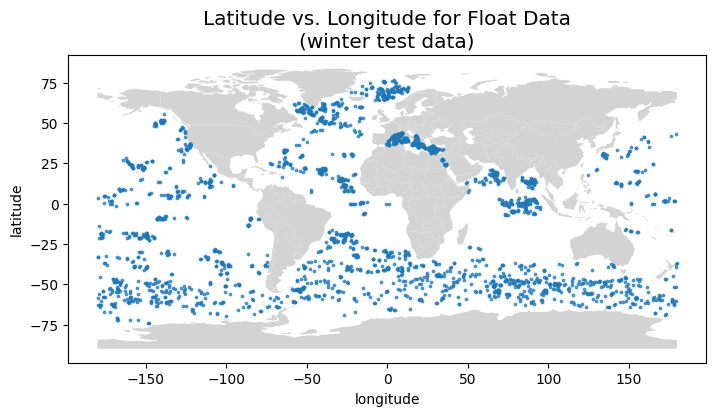

In [152]:
#Winter is the sparsest time of year
#Confirm that we have a good spread of the data for the test set
summer_test = test_set[test_set['seasonality'] ==3]
winter_test = test_set[test_set['seasonality'] ==1]
fall_test = test_set[test_set['seasonality'] ==4]
spring_test = test_set[test_set['seasonality'] ==2]
# plot_on_map(test_set,source='float', features='seasonality',data_type='discrete', subtitle='test data')
plot_on_map(winter_test,source='float', subtitle='winter test data')

# Model

In [153]:
#Separate entire data into train and test sets
df_train = df[df['float_cycle'].isin(train_set['float_cycle'].unique())].reset_index(drop=True)
df_test = df[df['float_cycle'].isin(test_set['float_cycle'].unique())].reset_index(drop=True)

In [154]:
#Drop uniformative columns & Split into x and y datasets
drop_cols = ['float','cycleNumber','float_cycle','CHLA']
x_train = df_train.drop(drop_cols,axis=1)
y_train = df_train[['CHLA']]
x_test = df_test.drop(drop_cols,axis=1)
y_test = df_test[['CHLA']]

In [155]:
xgb_model = XGBRegressor()
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [156]:
y_hat = xgb_model.predict(x_test)

MSE: 0.06059 (28.0%)


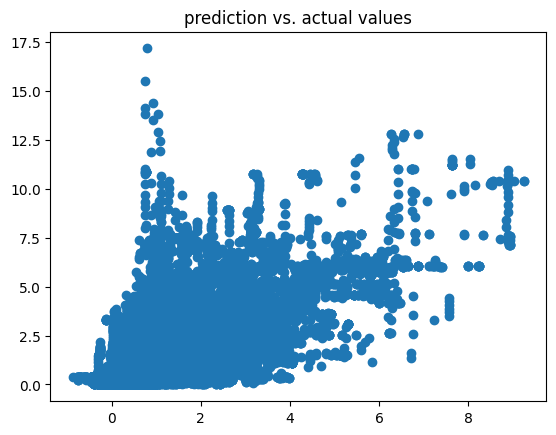

In [157]:
mse = round(mean_squared_error(y_test, y_hat),5)
mse_percent = round(mse/df['CHLA'].mean()*100,0)
print(f'MSE: {mse} ({mse_percent}%)')

_= plt.plot(y_hat,y_test,'o')
_ = plt.title('prediction vs. actual values')

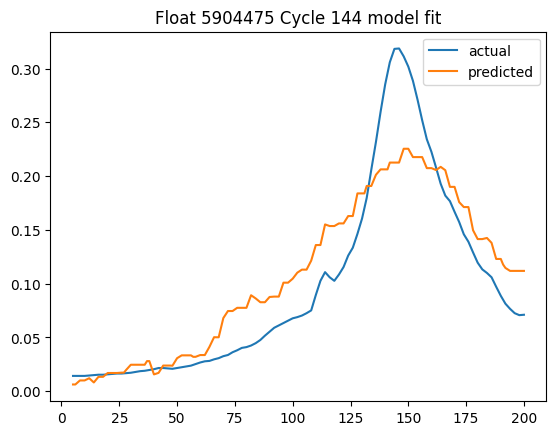

In [159]:
#view the output for a random sampled float
float_cycle_id = test_set.sample(1)['float_cycle'].reset_index(drop=True)[0]
test = df_test[df_test['float_cycle']==float_cycle_id]#'6903024_241']
#Good fit: 6901510_59
#ok fit: 6902897_185
#missing peak: 2902243_33
#bad fit: 6902548_220
y_pred = xgb_model.predict(test.drop(drop_cols,axis=1))
_ = plt.plot(test['PRES'],test['CHLA'])
_ = plt.plot(test['PRES'],y_pred)
_ = plt.legend(['actual','predicted'])
_ = plt.title('Float ' + float_cycle_id.split('_')[0]+ ' Cycle ' + float_cycle_id.split('_')[1]+ ' model fit')
_ = plt.show()

## Neural Network

In [235]:
#Need to remove any rows with N/A
df_train_new = df_train.dropna()
df_test_new = df_test.dropna()

In [236]:
#Drop uniformative columns & Split into x and y datasets
drop_cols = ['float','cycleNumber','float_cycle','CHLA']
x_train_new = df_train_new.drop(drop_cols,axis=1)
y_train_new = df_train_new[['CHLA']]
x_test_new = df_test_new.drop(drop_cols,axis=1)
y_test_new = df_test_new[['CHLA']]

In [255]:
sc1 = StandardScaler()
sc2 = StandardScaler()
x_train_scaled = sc1.fit_transform(x_train_new)
x_test_scaled = sc1.transform(x_test_new)
y_train_scaled = sc2.fit_transform(y_train_new)
y_test_scaled = sc2.transform(y_test_new)

In [267]:
# Define basic architecture - code from Pierre Gentine - ML for Environmental Engineering
nn_model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(x_train_scaled.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(4, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(x_train_scaled.shape[1],),
                       name='hidden_layer_2',),
    keras.layers.Dense(2, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(x_train_scaled.shape[1],),
                       name='hidden_layer_3',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define the optimizer 
optimizer = tf.optimizers.Adam()

nn_model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
nn_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 10)                130       
                                                                 
 hidden_layer_2 (Dense)      (None, 4)                 44        
                                                                 
 hidden_layer_3 (Dense)      (None, 2)                 10        
                                                                 
 output_layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [268]:
# Display training progress by printing a single dot for each completed epoch - code from Pierre Gentine - ML for Environmental Engineering class
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [269]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = nn_model.fit(x_train_scaled, y_train_scaled, epochs=100,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


...................................

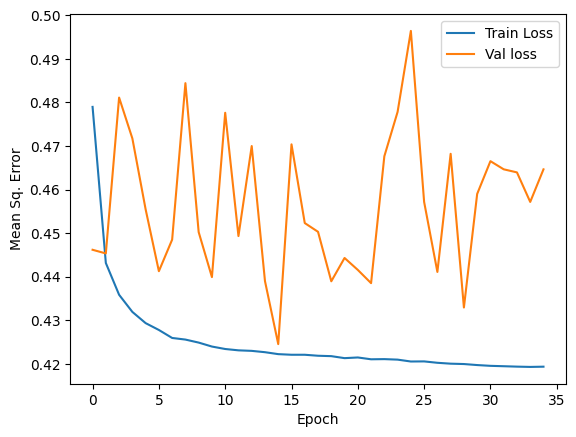

In [271]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Sq. Error')
plt.plot(history.epoch, np.array(history.history['loss']),
    label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
    label = 'Val loss')
plt.legend()